In [112]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install lightgbm
!pip install scikit-plot
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

print('✔️ Libraries Imported!')


✔️ Libraries Imported!


In [113]:
bank_df = pd.read_csv('/Users/user/Downloads/Churn_Modelling.csv')
print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(bank_df.shape[0], bank_df.shape[1]))
bank_df.head()

✔️ Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our Bank_DataFrame has 14 features and 10K customers/instances. The last feature, 'Exited', is the target variable and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [114]:
bank_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
bank_df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [115]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Apperently when we check the bank_df.info we will notice that there are no null values in our dataset which means we have a clean data

In [116]:
bank_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Key observations include:

The age of customers spans a range of 18 to 92, with an average value of around 40.
The average (and median) tenure is 5 years, indicating that most customers are loyal (with tenure > 3).
Roughly 50% of customers are active.
Prior to conducting exploratory data analysis (EDA), it's essential to establish a test set. This set should be set aside exclusively for evaluating our Machine Learning models. This precaution prevents data snooping bias (for more details, refer to page 51 of [1]), ensuring that the models are evaluated using unseen data. This practice is crucial for maintaining the integrity of our model assessment.







In [117]:
#from sklearn.model_selection import train_test_split
x = bank_df.drop('Exited', axis =1)
y = bank_df["Exited"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(x_train.shape[0], x_train.shape[1]))
print('Test set: {} rows x {} columns'.format(x_test.shape[0], x_test.shape[1]))

Train set: 8000 rows x 10 columns
Test set: 2000 rows x 10 columns


In [118]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Parameters and Variables Set!')


✔️ Default Parameters and Variables Set!


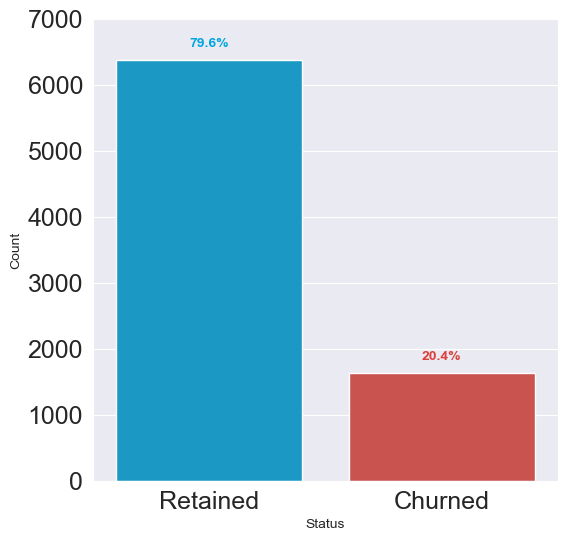

In [119]:
df_train = pd.concat([x_train, y_train], axis=1)
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=df_train, palette=colors, ax=ax)

for index, value in enumerate(df_train['Exited'].value_counts()):
    label = '{}%'.format(round((value / df_train['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size= 10)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);


The bank has managed to retain 80% of its customer base.

It's important to observe that our dataset exhibits a noticeable imbalance of the classes, as the 'Retained' class significantly outweighs the 'Churned' class in terms of the number of instances. Due to this imbalance, accuracy might not be the most appropriate metric for evaluating model performance.

Varying visualization methods are suitable for distinct types of variables. It's beneficial to distinguish between continuous and categorical variables and analyze them separately using relevant visualization techniques.

In [120]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


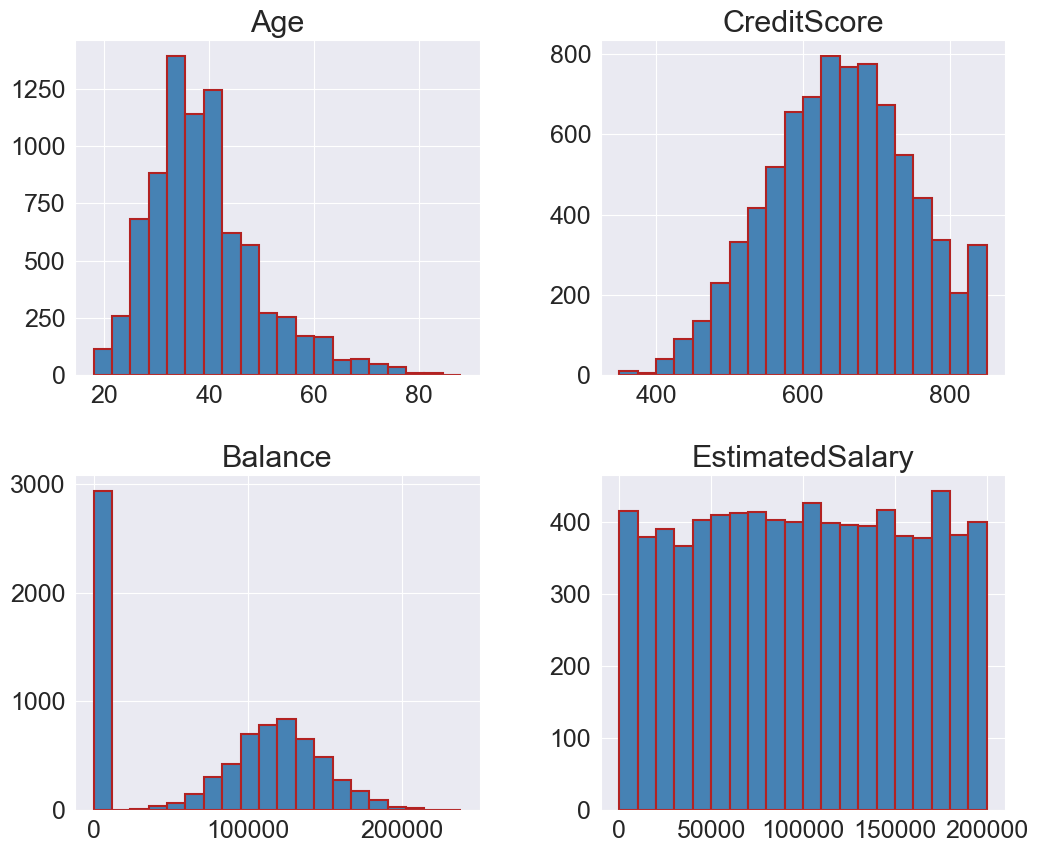

In [121]:

df_train[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

'Age' has more people with older ages on the right side of the middle point than on the left.
Most people's 'CreditScore' is higher than 600.
If we ignore the first group, 'Balance' looks like a regular curve.
'EstimatedSalary' is spread out evenly and doesn't tell us much.





Looking for Correlations

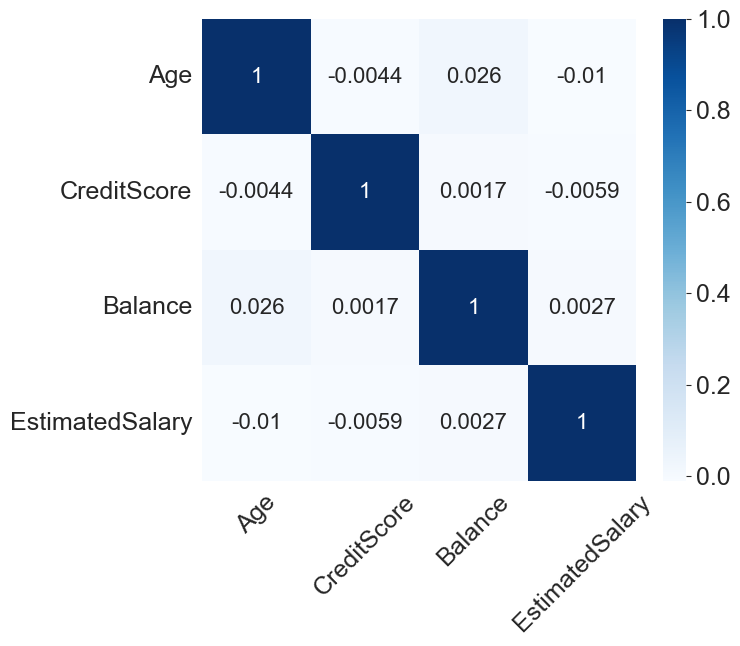

In [122]:

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(x_train[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

Our features don't show strong connections with each other, so we don't need to be concerned about them affecting each other.

Now, let's examine these features more closely.

CONTINOUS FEATURES

In [123]:
def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = df_train.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


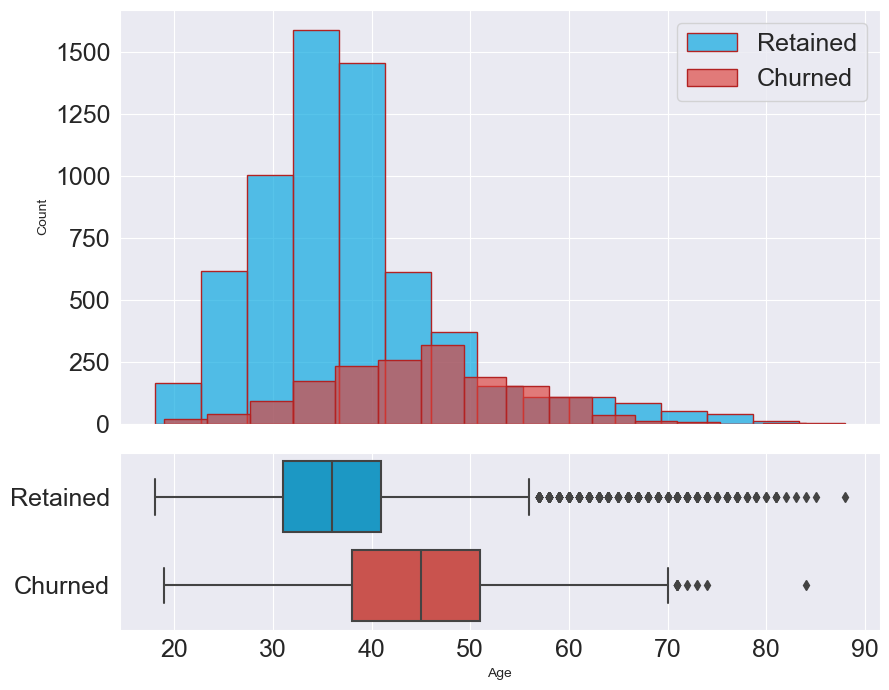

In [124]:
df_churned = df_train[df_train['Exited'] == 1]
df_retained = df_train[df_train['Exited'] == 0]

plot_continuous('Age')

It's notable that there's a distinct trend among different age groups, where older customers tend to churn more frequently. This suggests that customer preferences might shift with age, and the bank might need to adjust its approach to better cater to the needs of its older customers.

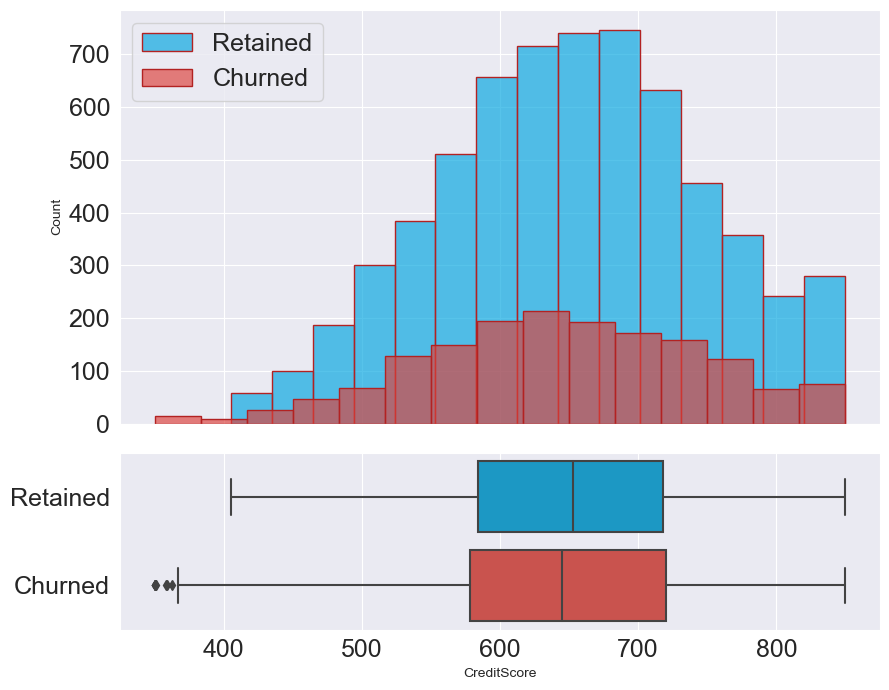

In [125]:
plot_continuous('CreditScore')

There is no significant difference between retained and churned customers in terms of their credit scores.



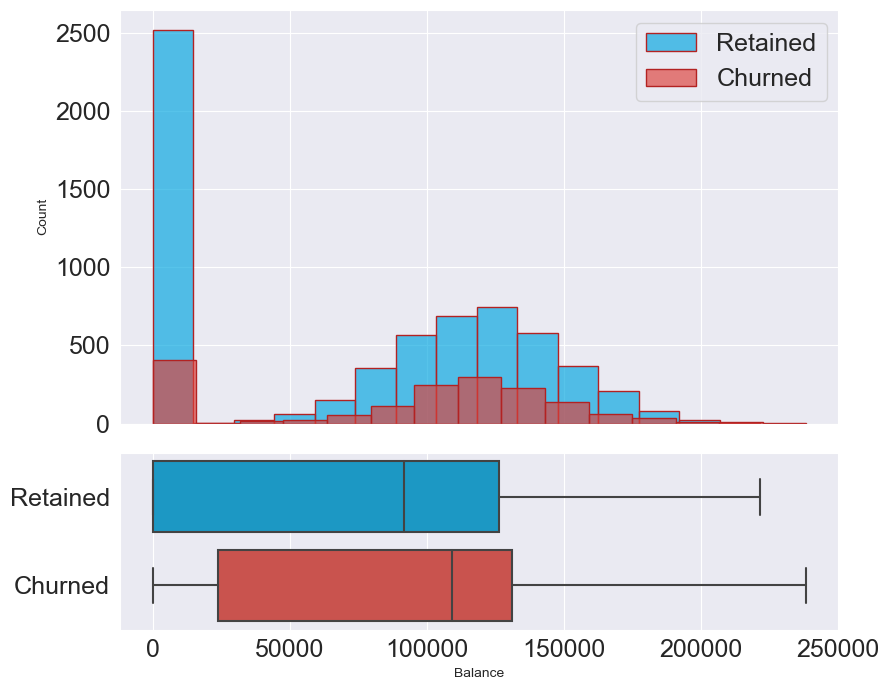

In [126]:
plot_continuous('Balance')


Once more, the two distributions appear quite alike. Many customers who didn't churn have a low account balance.


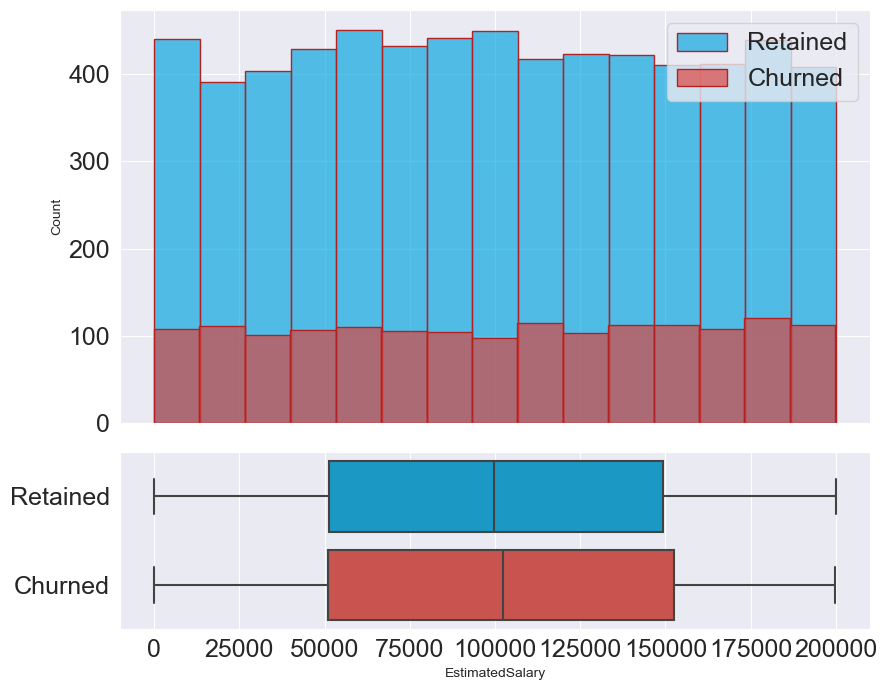

In [127]:
plot_continuous('EstimatedSalary')


Both Churned customers and Retained customers have similar and consistent salary distributions. This suggests that salary might not be a major factor in determining whether a customer is likely to leave.

CATEGORICAL FEATURES

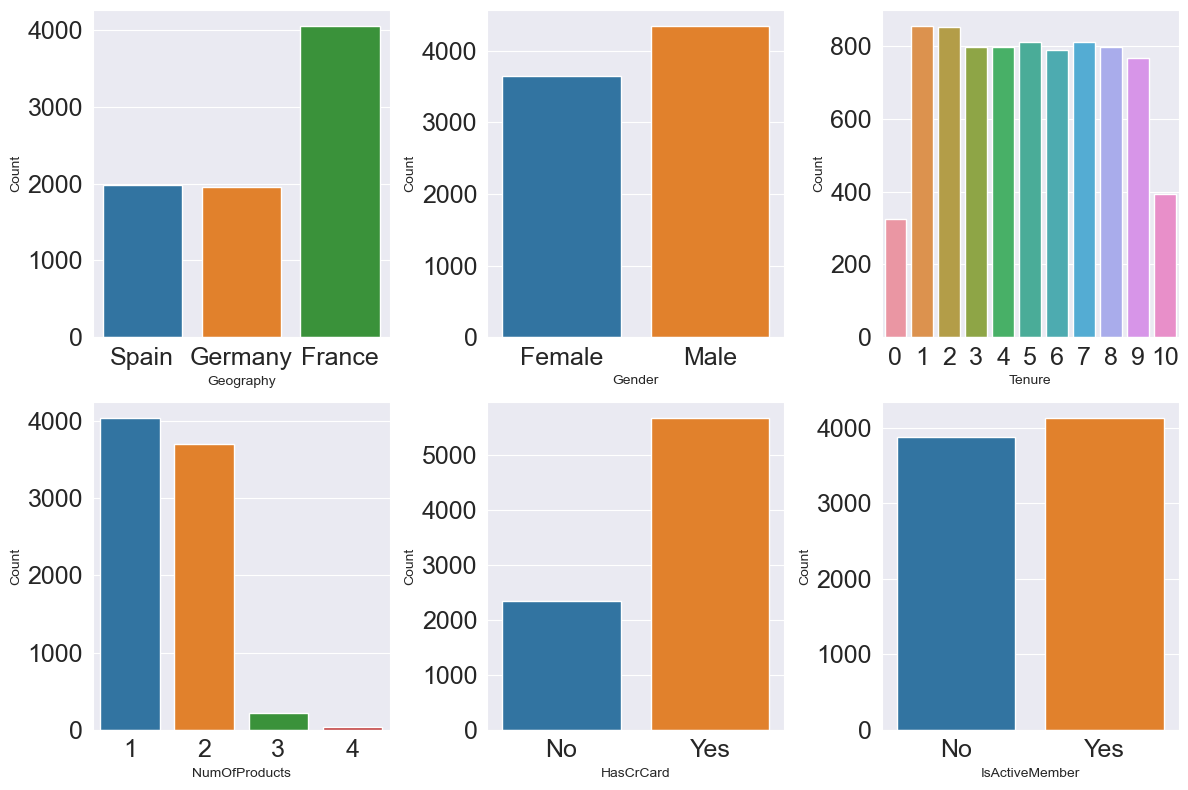

In [128]:
df_categorical = df_train[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_categorical.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=df_train) #palette=colors_categorical)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();


Important points:

The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
There are more male customers than females,
Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
A significant majority of customers has a credit card, and
Almost 50% of customers are not active.
Again, we will look at these features in greater detail.



In [129]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=df_train,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=df_train,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')
    
    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


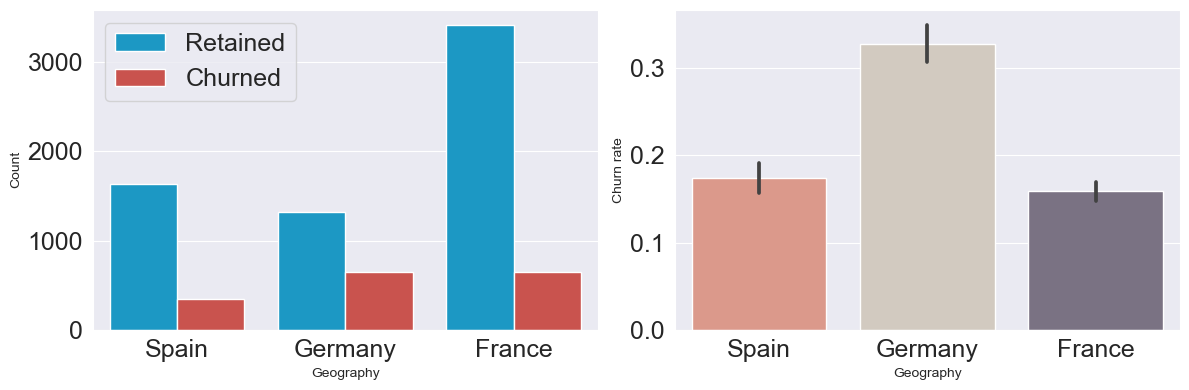

In [130]:
plot_categorical('Geography')


Here are some important points to consider:

The bank's customers come from three countries: France, Spain, and Germany. France has the most customers.
There are more male customers than female customers.
Only a small number of customers leave in the first year. The count of customers who stay for 1 to 9 years is about the same.
Most customers buy 1 or 2 products, while a few buy 3 or 4.
Many customers have a credit card.
About half of the customers are not very active.
Once again, let's take a closer look at these details.

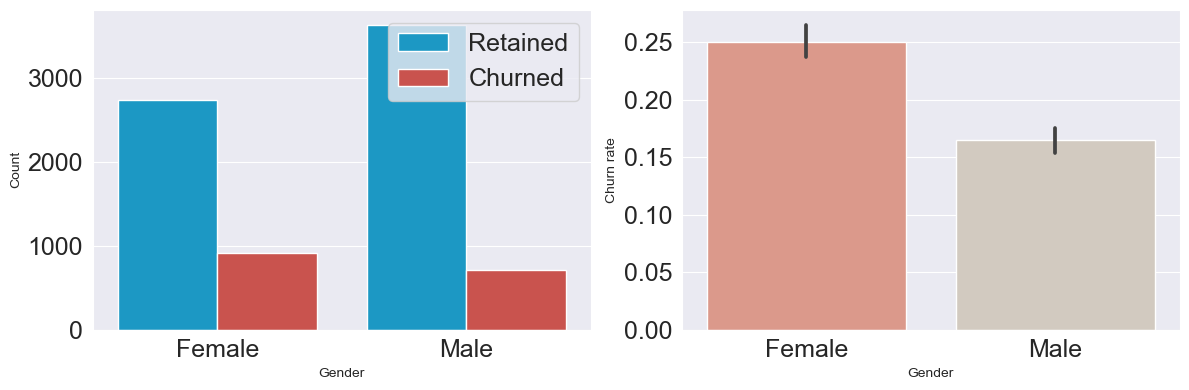

In [131]:
plot_categorical('Gender')

Female customers are more likely to churn.



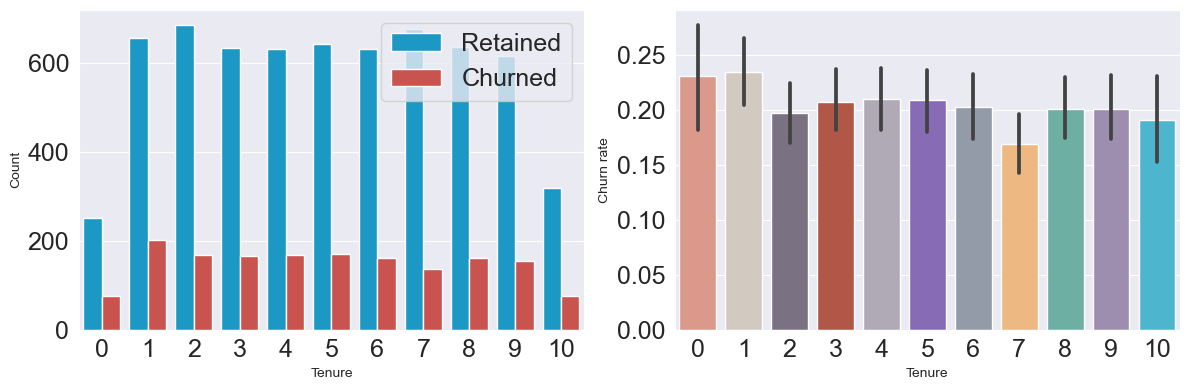

In [132]:
plot_categorical('Tenure')

The number of years (tenure) does not seem to affect the churn rate

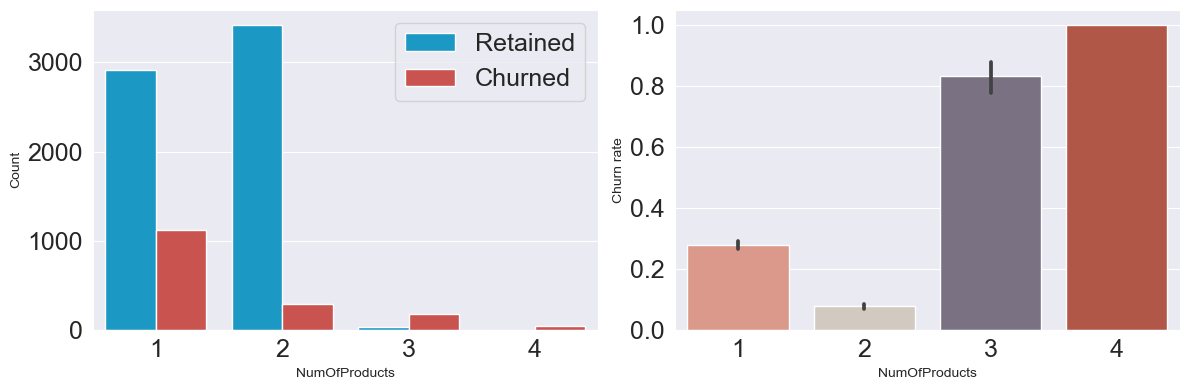

In [133]:
plot_categorical('NumOfProducts')

Surprisingly, having three or four products greatly raises the chance of customers leaving, possibly indicating that the bank might struggle to adequately serve customers with higher product counts, leading to more dissatisfaction.

In [134]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
df_train = df_train.drop(features_drop, axis=1)

print('✔️ Features Dropped!')


✔️ Features Dropped!


Encoding Categorical Features

In [135]:
encode = LabelEncoder()
df_train['Gender'] = encode.fit_transform(df_train['Gender'])
df_train['Geography'] = encode.fit_transform(df_train['Geography'])

print('✔️ Features Encoded!')
print(df_train.head())
unique = df_train['Geography'].nunique()
print(unique)



✔️ Features Encoded!
   CreditScore  Geography  Gender  Age    Balance  NumOfProducts  \
0          667          2       0   34       0.00              2   
1          427          1       1   42   75681.52              1   
2          535          0       0   29  112367.34              1   
3          654          2       1   40  105683.63              1   
4          850          2       0   57  126776.30              2   

   IsActiveMember  Exited  
0               0       0  
1               1       0  
2               0       0  
3               0       0  
4               1       0  
3


Scaling

In [136]:
scaler = StandardScaler()
scl_columns = ['CreditScore', 'Age', 'Balance']
df_train[scl_columns] = scaler.fit_transform(df_train[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


Dealing with Class Imbalance:
As observed earlier, there is an uneven distribution in the classes we want to predict, with one class (0 – retained) being more common than the other (1 - churned):

In [137]:
y_train.value_counts()

0    6368
1    1632
Name: Exited, dtype: int64

Class imbalance is a common challenge in many real-world tasks. When dealing with imbalanced data in classification, algorithms can end up favoring the majority class, resulting in models that simply predict the most common class. This can also make standard metrics misleading. For instance, if a dataset has 99.9% instances of class 0 and 0.01% instances of class 1, a classifier that always predicts class 0 could achieve 99.9% accuracy.

To tackle this issue, there are strategies available. One approach is to use the SMOTE (Synthetic Minority Oversampling Technique) algorithm. This method identifies similar records to the ones in the minority class and creates synthetic records that are a blend of the original and neighboring records, with weights assigned separately for each predictor.

I'll employ the SMOTE function from the imblearn library, setting the sampling_strategy to 'auto'.

In [138]:
# Prepare x_train and y_train
x_train = df_train.drop('Exited', axis=1)
y_train = df_train['Exited']

# Apply SMOTE
over = SMOTE(sampling_strategy='auto', random_state=0)
x_train, y_train = over.fit_resample(x_train, y_train)

print(y_train.value_counts())

0    6368
1    6368
Name: Exited, dtype: int64


In [139]:

df_test = pd.concat([x_test, y_test], axis=1)
df_test['Gender'] = encode.fit_transform(df_test['Gender'])
df_test['Geography'] = encode.fit_transform(df_test['Geography'])

features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
df_test = df_test.drop(features_drop, axis=1)

print('✔️ Features Dropped!')


df_test[scl_columns] = scaler.transform(df_test[scl_columns])  # not fit_transform, scaler has already been trained

y_test = df_test['Exited']
x_test = df_test.drop('Exited', 1)

print('✔️ Preprocessing Complete!')


✔️ Features Dropped!
✔️ Preprocessing Complete!


In [ ]:
Machine Learning

To predict bank customer churn, I will utilize the F1 score as my evaluation metric. This choice is driven by the F1 score's ability to strike a balance between pinpointing customers prone to churn (precision) and capturing a significant portion of genuine churn instances (recall). This equilibrium empowers the bank to efficiently direct efforts toward retaining valuable customers while minimizing unnecessary expenses. Ultimately, optimizing the F1 score empowers the bank to make well-informed choices, eThis improves how the bank keeps customers and makes its finances better.


Logistic Regression - Training Data Metrics:
Accuracy: 0.6921325376884422
Precision: 0.6538800150924412
Recall: 0.816425879396985
F1 Score: 0.7261680284936098
Best Threshold (Training): 0.4

Logistic Regression - Test Data Metrics:
Accuracy: 0.6035
Precision: 0.31523809523809526
Recall: 0.817283950617284
F1 Score: 0.45498281786941586
Best Threshold (Testing): 0.4

XGBoost - Training Data Metrics:
Accuracy: 0.9434673366834171
Precision: 0.9606851549755302
Recall: 0.9247801507537688
F1 Score: 0.9423907825252039
Best Threshold (Training): 0.5

XGBoost - Test Data Metrics:
Accuracy: 0.845
Precision: 0.6196473551637279
Recall: 0.6074074074074074
F1 Score: 0.6134663341645885
Best Threshold (Testing): 0.5

Gradient Boosting - Training Data Metrics:
Accuracy: 0.820037688442211
Precision: 0.785194514413658
Recall: 0.8811243718592965
F1 Score: 0.8303981056681959
Best Threshold (Training): 0.4

Gradient Boosting - Test Data Metrics:
Accuracy: 0.7445
Precision: 0.4309895833333333
Recall: 0.8172839

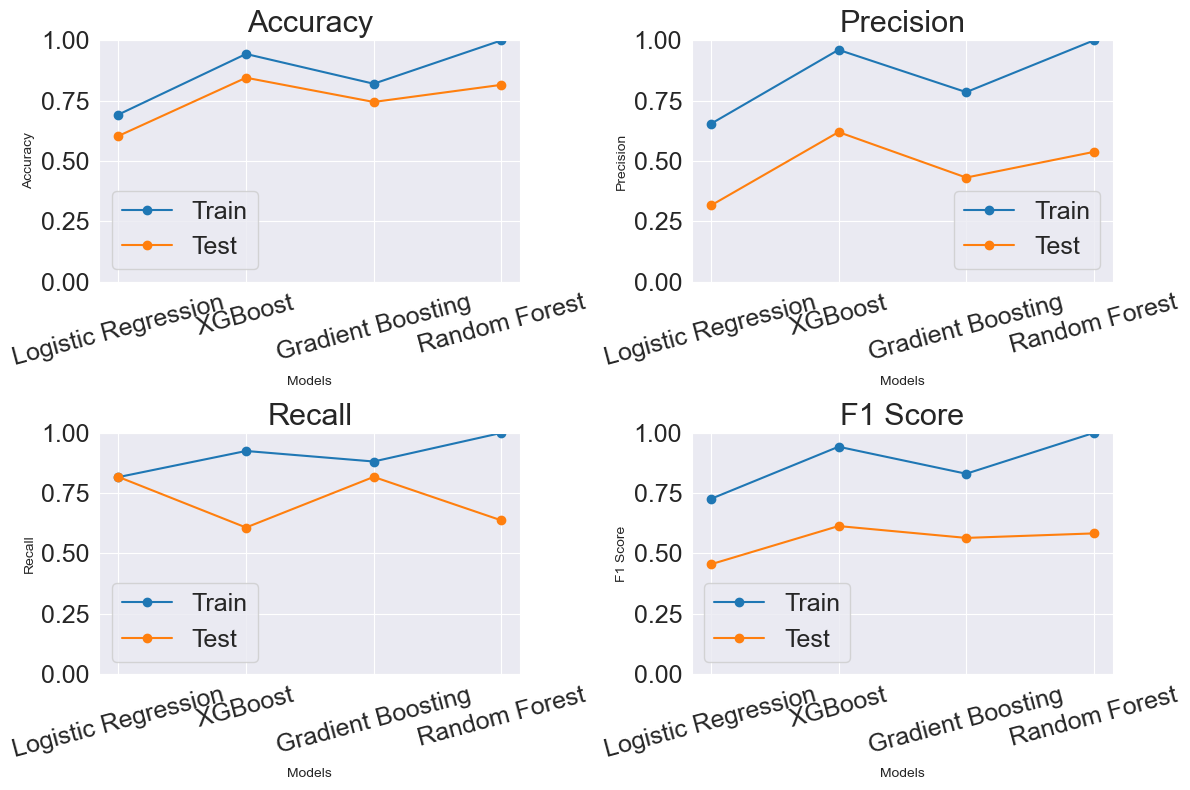

In [141]:
# Define a function to find the best threshold using cross-validation
def find_best_threshold(model, x, y, metric, threshold_range):
    best_threshold = None
    best_score = 0
    
    for threshold in threshold_range:
        y_pred_prob = cross_val_predict(model, x, y, cv=5, method='predict_proba')[:, 1]
        score = metric(y, y_pred_prob, threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold
            
    return best_threshold

# Define the metric for threshold optimization (e.g., F1-score)
def threshold_metric(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob >= threshold).astype(int)
    return f1_score(y_true, y_pred)

# Define the range of thresholds to explore
threshold_range = np.linspace(0.1, 0.9, 9)  # Adjust the range as needed

# Train your models
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(x_train, y_train)

gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting.fit(x_train, y_train)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(x_train, y_train)

# Find the best threshold using cross-validation on the training data
best_threshold_logreg = find_best_threshold(logreg, x_train, y_train, threshold_metric, threshold_range)
best_threshold_xgb = find_best_threshold(xgb_model, x_train, y_train, threshold_metric, threshold_range)
best_threshold_gb = find_best_threshold(gradient_boosting, x_train, y_train, threshold_metric, threshold_range)
best_threshold_rf = find_best_threshold(random_forest, x_train, y_train, threshold_metric, threshold_range)

# Function to evaluate a model on the test data using a given threshold
def evaluate_model_with_threshold(model, x, y, threshold):
    y_pred_prob = model.predict_proba(x)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return accuracy, precision, recall, f1

# Evaluate models on both training and test data with best thresholds
train_metrics = []
test_metrics = []

models = [logreg, xgb_model, gradient_boosting, random_forest]
best_thresholds = [best_threshold_logreg, best_threshold_xgb, best_threshold_gb, best_threshold_rf]
model_names = ['Logistic Regression', 'XGBoost', 'Gradient Boosting', 'Random Forest']

for model, threshold, model_name in zip(models, best_thresholds, model_names):
    train_accuracy, train_precision, train_recall, train_f1 = evaluate_model_with_threshold(model, x_train, y_train, threshold)
    test_accuracy, test_precision, test_recall, test_f1 = evaluate_model_with_threshold(model, x_test, y_test, threshold)
    
    train_metrics.append((train_accuracy, train_precision, train_recall, train_f1))
    test_metrics.append((test_accuracy, test_precision, test_recall, test_f1))
    
    print(f"{model_name} - Training Data Metrics:")
    print("Accuracy:", train_accuracy)
    print("Precision:", train_precision)
    print("Recall:", train_recall)
    print("F1 Score:", train_f1)
    print("Best Threshold (Training):", threshold)
    print()
    
    print(f"{model_name} - Test Data Metrics:")
    print("Accuracy:", test_accuracy)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("F1 Score:", test_f1)
    print("Best Threshold (Testing):", threshold)
    print()
    
import matplotlib.pyplot as plt

# Extract metrics for plotting
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metric_values = np.array(train_metrics).T
test_metric_values = np.array(test_metrics).T

# Plotting
plt.figure(figsize=(12, 8))

for i, metric_name in enumerate(metric_names):
    plt.subplot(2, 2, i + 1)
    plt.plot(model_names, train_metric_values[i], marker='o', label='Train')
    plt.plot(model_names, test_metric_values[i], marker='o', label='Test')
    plt.title(metric_name)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.legend()

plt.tight_layout()
plt.show()


The models evaluates the performance of Logistic Regression, XGBoost, Gradient Boosting, and Random Forest models for predicting customer churn. It optimizes thresholds using cross-validation and a specified range. The evaluation metrics include accuracy, precision, recall, and F1 score. The F1 score is used as a primary metric to balance precision and recall. The best thresholds are found for each model using cross-validation on the training data. A function evaluates each model's performance on training and test data with the best threshold. 
Based on my output, the model with the highest F1 score on the test dataset is XGBoost. however i think it would be best if i include some validation step


model validation

Logistic Regression - Test Data Metrics:
Accuracy: 0.6015
Precision: 0.31404174573055027
Recall: 0.817283950617284
F1 Score: 0.4537354352296093
Best Threshold (Testing): 0.4

XGBoost - Test Data Metrics:
Accuracy: 0.8255
Precision: 0.5578512396694215
Recall: 0.6666666666666666
F1 Score: 0.6074240719910011
Best Threshold (Testing): 0.4

Gradient Boosting - Test Data Metrics:
Accuracy: 0.799
Precision: 0.5024793388429752
Recall: 0.7506172839506173
F1 Score: 0.6019801980198021
Best Threshold (Testing): 0.5

Random Forest - Test Data Metrics:
Accuracy: 0.816
Precision: 0.5378323108384458
Recall: 0.6493827160493827
F1 Score: 0.5883668903803132
Best Threshold (Testing): 0.5



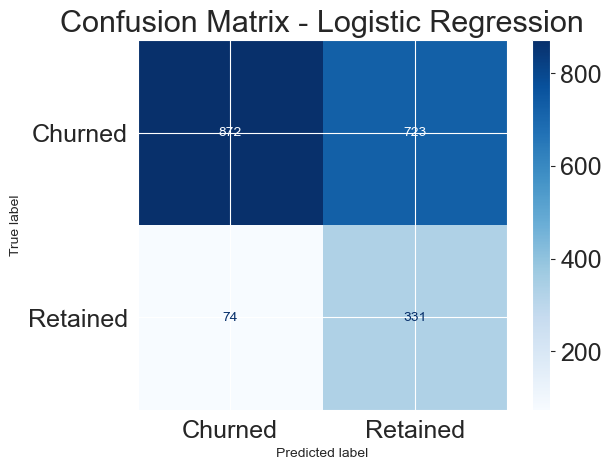

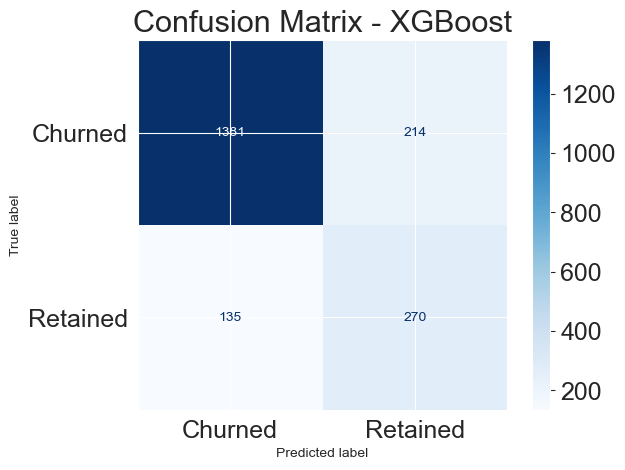

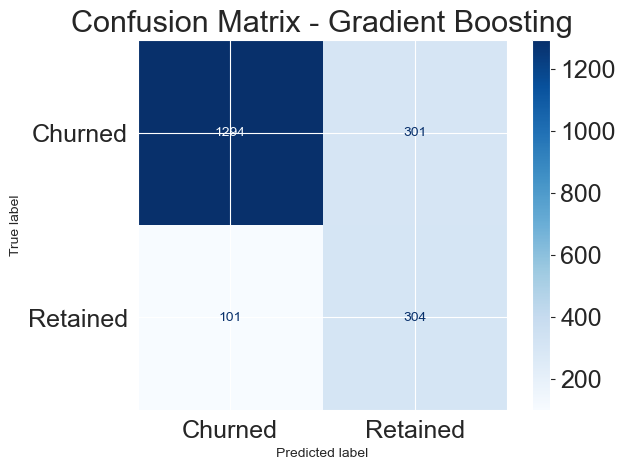

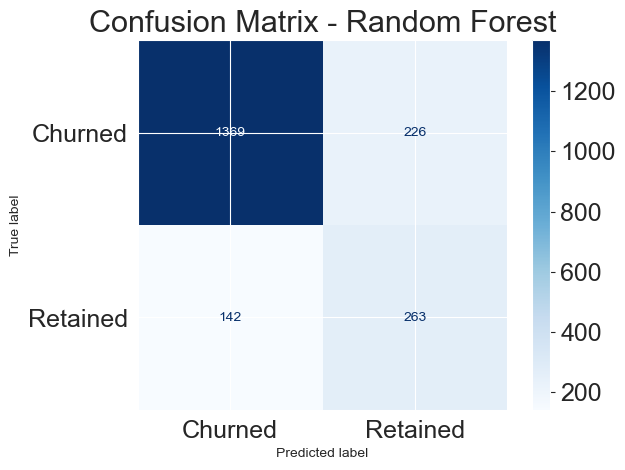

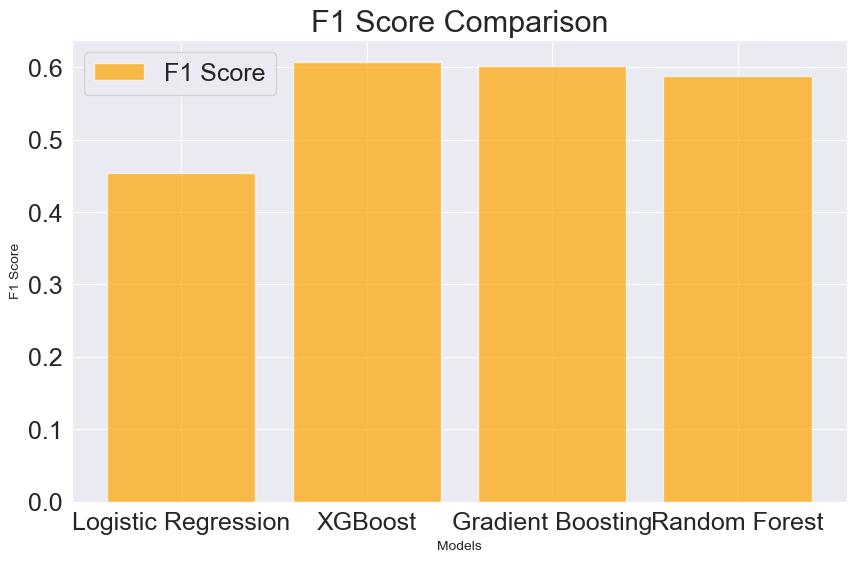

In [146]:
# Split the original training data into new training and validation sets
from sklearn.model_selection import train_test_split

x_new_train, x_val, y_new_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Train your models using the new training set
logreg = LogisticRegression()
logreg.fit(x_new_train, y_new_train)

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(x_new_train, y_new_train)

gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting.fit(x_new_train, y_new_train)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(x_new_train, y_new_train)

# Find the best threshold using cross-validation on the validation data
best_threshold_logreg = find_best_threshold(logreg, x_val, y_val, threshold_metric, threshold_range)
best_threshold_xgb = find_best_threshold(xgb_model, x_val, y_val, threshold_metric, threshold_range)
best_threshold_gb = find_best_threshold(gradient_boosting, x_val, y_val, threshold_metric, threshold_range)
best_threshold_rf = find_best_threshold(random_forest, x_val, y_val, threshold_metric, threshold_range)

# Evaluate models on the test data with best thresholds
test_metrics = []

models = [logreg, xgb_model, gradient_boosting, random_forest]
best_thresholds = [best_threshold_logreg, best_threshold_xgb, best_threshold_gb, best_threshold_rf]
model_names = ['Logistic Regression', 'XGBoost', 'Gradient Boosting', 'Random Forest']

for model, threshold, model_name in zip(models, best_thresholds, model_names):
    test_accuracy, test_precision, test_recall, test_f1 = evaluate_model_with_threshold(model, x_test, y_test, threshold)
    
    test_metrics.append((test_accuracy, test_precision, test_recall, test_f1))
    
    print(f"{model_name} - Test Data Metrics:")
    print("Accuracy:", test_accuracy)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("F1 Score:", test_f1)
    print("Best Threshold (Testing):", threshold)
    print()
   
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix for each model on test data
for model, model_name, threshold in zip(models, model_names, best_thresholds):
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Churned', 'Retained'])
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()



# Plot F1 Scores for all models
f1_scores = []

for model, model_name in zip(models, model_names):
    _, _, _, test_f1 = evaluate_model_with_threshold(model, x_test, y_test, best_thresholds[model_names.index(model_name)])
    f1_scores.append(test_f1)

plt.figure(figsize=(10, 6))
plt.bar(model_names, f1_scores, label='F1 Score', color='orange', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
plt.show()


The performance of each model, with a focus on F1 score as the primary evaluation metric. 
Based on the output Logistic Regression achieved a relatively low F1 score of 0.454, indicating a challenge in balancing precision and recall. 

XGBoost displayed a better F1 score of 0.607, suggesting a more balanced trade-off between identifying true positives and controlling false positives. 

Gradient Boosting followed with an F1 score of 0.602, showcasing a reasonable harmony between precision and recall. 

Random Forest exhibited an F1 score of 0.588, suggesting a decent equilibrium between precision and recall, albeit slightly lower than the others. 

Overall, XGBoost emerged as the leader among the models, with the highest F1 score, signifying its effectiveness in capturing both positive cases and minimizing false positives. 

Conclusions
Our final report to the bank should be based on two main points:

 help us identify which features contribute to customer churn. Additionally, our visualization help us to see the importance of each feature in predicting the likelihood of churn. Our results reveal that the age feature(older customers are more likely to churn), followed by the number of products (having more products increases a customer’s likelihood to churn). The bank could use our findings to adapt and improve its services in a way that increases satisfaction for those customers more likely to churn.

We can build several machine learning models with f1 score approximately equal to 60%, meaning that they can signify its effectiveness in capturing both positive cases and minimizing false positives. 
Perhaps, adding more features or/and records could help us improve predictive performance. Therefore, the bank could benefit from investing in gathering more data.



